<a href="https://colab.research.google.com/github/Mohammed-Abdul-Rafe-Sajid/Analysing-LogLLM-and-their-possible-improvements/blob/main/Changes_in_LogLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re

# Open raw log file
with open("HDFS_2k.log", "r") as f:
    raw_logs = f.readlines()

# Function to preprocess each log line
def preprocess_log(line):
    # Remove timestamps (like 2008-08-01 00:00:00,347)
    line = re.sub(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+', '', line)
    # Replace all numbers with <NUM>
    line = re.sub(r'\d+', '<NUM>', line)
    # Strip leading/trailing spaces
    return line.strip()

# Apply preprocessing
cleaned_logs = [preprocess_log(line) for line in raw_logs]

# Print first 5 cleaned logs
for log in cleaned_logs[:5]:
    print(log)


<NUM> <NUM> <NUM> INFO dfs.DataNode$PacketResponder: PacketResponder <NUM> for block blk_<NUM> terminating
<NUM> <NUM> <NUM> INFO dfs.DataNode$PacketResponder: PacketResponder <NUM> for block blk_-<NUM> terminating
<NUM> <NUM> <NUM> INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: <NUM>.<NUM>.<NUM>.<NUM>:<NUM> is added to blk_<NUM> size <NUM>
<NUM> <NUM> <NUM> INFO dfs.DataNode$PacketResponder: PacketResponder <NUM> for block blk_<NUM> terminating
<NUM> <NUM> <NUM> INFO dfs.DataNode$PacketResponder: PacketResponder <NUM> for block blk_-<NUM> terminating


In [2]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Example: convert first 5 cleaned logs
embeddings = []

for log in cleaned_logs[:5]:
    inputs = tokenizer(log, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    # Take mean of token embeddings to get single vector per log line
    embedding = outputs.last_hidden_state.mean(dim=1)
    embeddings.append(embedding.detach().numpy())

# Check the shape of first embedding
print("Shape of first embedding:", embeddings[0].shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Shape of first embedding: (1, 768)


In [3]:
import numpy as np

labels = []

for log in cleaned_logs[:5]:  # start with first 5 logs, can extend later
    if "ERROR" in log:
        labels.append(1)
    else:
        labels.append(0)

# Convert embeddings list to numpy array
X = np.vstack(embeddings)
y = np.array(labels)

print("X shape:", X.shape)
print("y:", y)


X shape: (5, 768)
y: [0 0 0 0 0]


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



# LETS DO FOR ALL LOGS

In [5]:
# Preprocess all logs
cleaned_logs = [preprocess_log(line) for line in raw_logs]

# Generate embeddings for all logs
embeddings = []
for log in cleaned_logs:
    inputs = tokenizer(log, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1)
    embeddings.append(embedding.detach().numpy())
X = np.vstack(embeddings)


In [8]:
print("Embeddings shape:", X.shape)  # Should be (num_logs, 768)



Embeddings shape: (2000, 768)


In [15]:
import pandas as pd
csv_file_path = "/content/HDFS_2k.log_structured.csv"
df = pd.read_csv(csv_file_path)
print("CSV Columns:", df.columns)


CSV Columns: Index(['LineId', 'Date', 'Time', 'Pid', 'Level', 'Component', 'Content',
       'EventId', 'EventTemplate'],
      dtype='object')
   LineId   Date    Time  Pid Level                     Component  \
0       1  81109  203615  148  INFO  dfs.DataNode$PacketResponder   
1       2  81109  203807  222  INFO  dfs.DataNode$PacketResponder   
2       3  81109  204005   35  INFO              dfs.FSNamesystem   
3       4  81109  204015  308  INFO  dfs.DataNode$PacketResponder   
4       5  81109  204106  329  INFO  dfs.DataNode$PacketResponder   

                                             Content EventId  \
0  PacketResponder 1 for block blk_38865049064139...     E10   
1  PacketResponder 0 for block blk_-6952295868487...     E10   
2  BLOCK* NameSystem.addStoredBlock: blockMap upd...      E6   
3  PacketResponder 2 for block blk_82291938032499...     E10   
4  PacketResponder 2 for block blk_-6670958622368...     E10   

                                       EventTemplate  
0

In [16]:
# Step 5: Define anomaly EventIds (example, beginner-friendly)
anomalous_ids = ['E1', 'E2', 'E4', 'E5', 'E9']
y = df['EventId'].apply(lambda x: 1 if x in anomalous_ids else 0).values
print("Label distribution (Normal=0, Anomaly=1):", np.bincount(y))

Label distribution (Normal=0, Anomaly=1): [1650  350]


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       327
           1       1.00      1.00      1.00        73

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



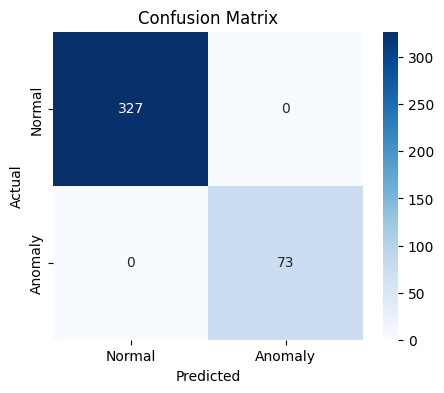

In [17]:
# Step 8: Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 10: Predictions
y_pred = clf.predict(X_test)

# Step 11: Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Labels distribution (Normal=0, Anomaly=1): [1991    9]
